In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/philhoonoh/os/blob/main/lecture_summary/06_Chapter6_part2.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View Source</a>
  </td>
</table>

# Chapter 6. Synchronization Tools
#### Contents
    - 6.5 Mutex Locks
    - 6.6 Semaphores
    - 6.7 Monitors
    - 6.8 Liveness

# Higher-level software tools(primitives) to solve the CSP
- Software Solutions(such as like Peterson's Algorithm) & Hardware Solutions(such as atomic variables) are __complicated__ as well as __generally inaccessible__ to application programmers  

- operating-system designers build __higher-level software tools__ to solve the critical-section problem 

a. __Mutex Locks__ 
    - the simplest tools for synchronization.
    - solution for mutual exclusion
    
b. __Semaphore__
    - more robust, convenient, and effective tool.
    - solution for mutual exclusion
    
c. __Monitor__
    - overcomes the demerits of mutex and semaphore.
    - solution for mutual exclusion
    
d. __Liveness__
    - ensures for processes to make progress.
    - solution for mutual exclusion, deadlocks

# 6.5 Mutex Locks

### Mutex Locks
- mutex stands for __Mutual Exclusion__
- Locking mechanism
- Only One Resource at a time (Think of only one toilet)
- protect critical sections and thus prevent race conditions
- process must acquire the lock before entering a critical section
- releases the lock when it exits the critical section
- __Note that mutex locks only satisfy mutual exclusion__
- Whereas Peterson's Algorithm (only for 2 processes) satifies three requirements for critical section problem
    - mutual exclusion
    - progress - deadlock
    - bounded waiting - starvation

### Mutex Locks functions & variable
- __acquire__ function 
    - acquires the lock
- __release__ function
    - releases the lock
- boolean variable __available__ 
    - indicates if the lock is available or not

### Solution to the critical-section problem using mutex locks
```c
while (true) {
    /* acquire lock */
        critical section
    /* release lock */
        remainder section
}
```

### Definition of acquire & release
```c
acquire(){
    while (!available) 
        ; /* busy waiting - wait until lock is avaialble */
    available = false;
}

release(){
    available = true;
}
```
- acquire(), release() must be performed __atomically__
- Thus mutex locks can be implemented using the compare_and_swap operation

### Busy waiting
- any other process that tries to enter its critical section must loop continuously in the call to acquire()
- clearly a problem in a real multiprogramming system
    - where a single CPU core is shared among many processes
- wastes CPU cycles that some other process might be able to use productively

### Spinlock
- the type of mutex lock using the method of __busy waiting__
- process spins while waiting for the lock to become available
- Spinlocks do have an __advantage__
    - in that no context switch is required waiting on a lock
- In certain circumstances on multi-core systems, spinlocks are in fact the __preferable choice for locking__
    - one thread can “spin” on one processing core
    - while another thread performs its critical section on another core
    
    
### Mutex Lock Example
```c
#include <stdio.h>
#include <pthread.h>

int sum = 0;

pthread_mutex_t mutex;

int main()
{
    pthread_t tid1, tid2;
    pthread_mutex_init(&mutex, NULL);
    pthread_create(&tid1, NULL, counter, NULL);
    pthread_create(&tid2, NULL, counter, NULL);
    pthread_join(tid1, NULL);
    pthread_join(tid2, NULL);
    printf("sum = %d\n", sum);
}

void *counter(void *param)
{
    int k;
    for(k=0;k<10000;k++){
        /* entry section */
        pthread_mutex_lock(&mutex);
        
        /* critical section */
        sum++;
        
        /* exit section */
        pthread_mutex_unlock(&mutex);
        
        /* remainder section */
    }
    pthread_exit(0);
}
```
- Expected value = 20000
- Actual value = 20000

# 6.6 Semaphores

### Semaphores
- Signaling mechanism
- Multiple Resources (Think of multiple toilets)

### Semaphore S
- integer variable
- Only accessed through two standard atomic operations
    - wait() - P
    - signal() - V
    
### Definition of wait & signal
```c
wait(S){
    while (S<=0)
        ; /* busy waiting */
    S --;
}

singal(S){
    S++;
}
```
- All modifications to the integer value of the semaphore 
    - in the wait() and signal() operations must be executed __atomically__
    
### Binary Semaphore
- range only between 0 and 1
- behave similarly to mutex locks

### Counting Semaphore
- range over an unrestricted domain
- used to control access to a given resource consisting of a finite number of instances  
a) Initialize semaphore to __the number of resources available__  
b) When a process uses a resource,   
         it performs a wait() operation: decrementing the count  
c) When a process releases a resource,   
        it performs a signal() operation: incrementing the count   
d) When the count for the semaphore goes to 0, all resources are being used  
        Then processes that wish to use a resource will block until the count becomes greater than 0
        
        
### Counting Semaphore Usuage
- Consider two processes $P_{1}$ and $P_{2}$ running concurrently
    - $P_{1}$ with a statement $S_{1}$, and $P_{2}$ with a statement $S_{2}$ 
- Suppose that $S_{2}$ should be executed only after $S_{1}$ has completed
    - Let $P_{1}$ and $P_{2}$ share a semaphore __synch__, initialized to 0.
    
- In process $P_{1}$, insert  
    $S_{1}$;  
    signal(synch);
    
    
- In process $P_{2}$, insert  
    wait(synch);  
    $S_{2}$;
    
### Semaphore Implementation
- Semaphores also suffer from the problem of __busy waiting__
- To overcome this problem, modify the definition of P() and V()  
   
   
- When a process executes the wait() operation
    - and finds that the semaphore is not positive, it must wait
    - rather than busy waiting, suspend itself and goes to the waiting queue
- When other process executes the signal() operation
    - waiting processes can be restarted and placed into the ready queue
- The process is restarted by a __wakeup() operation__, which changes the process from the waiting state to the ready state.


### Definition of semaphore, wait, signal w/ wakeup operation
```java
typedef struct {
    int value;
    struct process *list;
}semaphore;

wait(semaphore *S){
    S->value--;
    if (S->value < 0){
        add this process to S->list;
        sleep();
    }
}

signal(semaphore *S){
    S->value++;
    if (S->value <= 0){
        remove a process P from S->list;
        wakeup(P)
    }
}
```
- semaphore has an integer value and a list of processes list
- When a process must wait on a semaphore, it is added to the list of processes
- A signal() operation removes one process from the list of waiting processes and awakens that process
- __wakeup operation implementation__ 
    - semaphore values may be negative (whereas semaphore values with busy waiting are never negative) 
    - $\vert negative \ semaphore \ value \vert$ $=$ the number of processes waiting on that semaphore
    - This fact results from switching the order of the decrement and the test in the implementation of the wait() operation
    
### Semaphore Example (Binary) 

```c
#include <stdio.h>
#include <pthread.h>
#include <semaphore.h>

int sum = 0;  // a shared variable

sem_t sem;

void *counter(void *param)
{
    int k;
    for (k = 0; k < 10000; k++) {
        /* entry section */
        sem_wait(&sem);
        
        /* critical section */
        sum++;
        
        /* exit section */
        sem_post(&sem);
        
        /* remainder section */
    }
    pthread_exit(0);
}

int main()
{
    pthread_t tid1, tid2;
    sem_init(&sem, 0, 1);
    pthread_create(&tid1, NULL, counter, NULL);
    pthread_create(&tid2, NULL, counter, NULL);
    pthread_join(tid1, NULL);
    pthread_join(tid2, NULL);
    printf("sum = %d\n", sum);
}
```
- Expected Result = 20000
- Acutal Result = 20000

### Semaphore Example

```c
#include <stdio.h>
#include <pthread.h>
#include <semaphore.h>

int sum = 0;  // a shared variable

sem_t sem;

void *counter(void *param)
{
    int k;
    for (k = 0; k < 10000; k++) {
        /* entry section */
        sem_wait(&sem);
        
        /* critical section */
        sum++;
        
        /* exit section */
        sem_post(&sem);
        
        /* remainder section */
    }
    pthread_exit(0);
}

int main()
{
    pthread_t tid[5];
    int i;
    sem_init(&sem, 0, 5);
    
    for(i = 0; i < 5; i++)
        pthread_create(&tid[i], NULL, counter, NULL);
    for(i = 0; i< 5; i++)
        pthread_join(tid[i], NULL);
    printf("sum = %d\n", sum);
}
```
- Expected Result $=$ 50000
- Acutal Result $\neq$ 50000
- Mutual Exclusion is not met!
- sum is __shared variable__ 
- sum needs to be sum[5] (equal to the number of resources)

# 6.7 Monitors

### Limitations of semaphores
- semaphores provide a convenient and effective mechanism for process synchronization  
- __;however timing errors that are difficult to detect can occur__
    - timing errors can still occur even with __mutex locks, semaphores__
    - must observed seqeunce
        - for mutex locks : _acquire_ & _release_ sequence 
        - for semaphores : _wait_ & _signal_ sequence 
    - if above sequence is not preserved, mutual exclusion is not preserved
- Using semaphores or mutex locks incorrectly to solve the critical-section problem happens quite well, especially when synchronizing a number of critical sections in code.
    
### Examples of semphores problem
- e.g.1) semaphores : __signal__ and __wait__ sequence results in all the threads acceessing to critrical section
- e.g.2) semaphores : __wait__ and __wait__ sequence results in permanant blocks
- e.g.3) semaphores : omits __wait__ or __singal__ sequence results in violation of mutual exclusion or permanent block of process, respectively 

### Monitor
- fundamental high-level synchronization construct
- __ADT__ that includes a set of programmer-defined operations that are provided with mutual exclusion within the monitor
- mutual exclusion 을 쉽게 관리해주는 ADT 이다. 

#### What is ADT ?
- An abstract data type—or __ADT__ — encapsulates data with a set of functions to operate on that data that are independent of any specific implementation of the ADT
- John DeNero(Professor at UC Berkeley) pointed out that the quality of  Programmer is measured by how well constructing an __ADT(or Data Abstraction)__, believe or not :)
- Think of __Java's Class__ or __Python's Class__

### Pseudocode syntax of a monitor
```c
monitor monitor name
{
    /* shared variable declarasions */
    function P1(...){
        ...
    }
    function P1(...){
        ...
    }
    .
    .
    .
    function P1(...){
        ...
    }
    
    initialization_code(...){
        ...
    }
}
```


### Schematic view of monitor
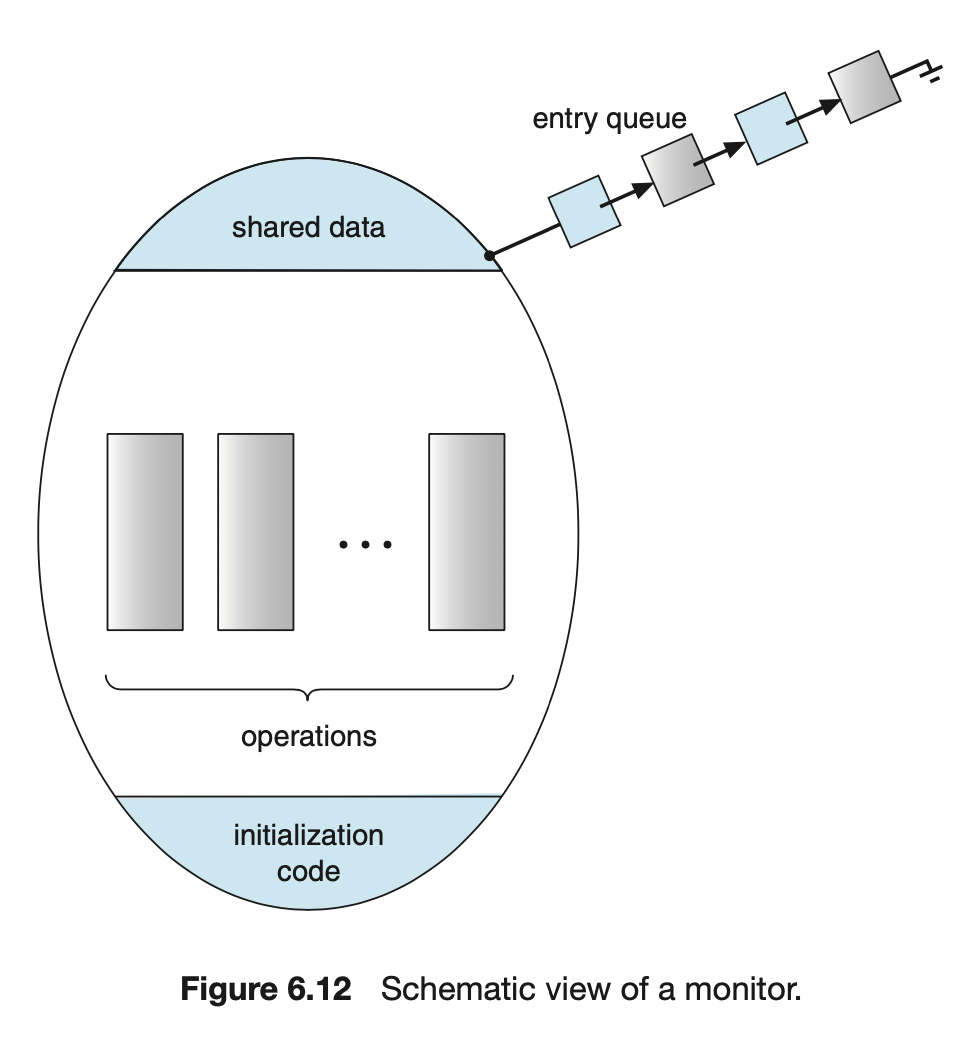
- Not sufficiently powerful for modeling some synchronization schemes
    - such as constructing order among processes - Synchronous Patterns (execute X first, then execute Y) 
    

### __condition(conditional variable)__ 
- tailor-made synchronization scheme can define one or more variables of type __condition__
- only operations that can invoke on conditional variabels
    - wait()
    - siginal() 

```c
# define conditions
condition x, y;

# thread waiting x's signal until 
x.wait();

# other process invokes
x.singal();

```

### Two possibilities in Conditional Variables
- Let process P is associated with x.signal();
- Let process Q is associated with x.wait();

#### Signal and wait
- P invoke x.signal(); P waits; Q invoked by x.wait(); Q leaves the monitor; P resumes
- P invoke x.singal(); P waits until other condition

#### Signal and continue
- P invoke x.signal(); P continue; P leaves the monitor; Q invoked by x.wait(); 
- Q waits until other condition

### Monitor with condition variables.
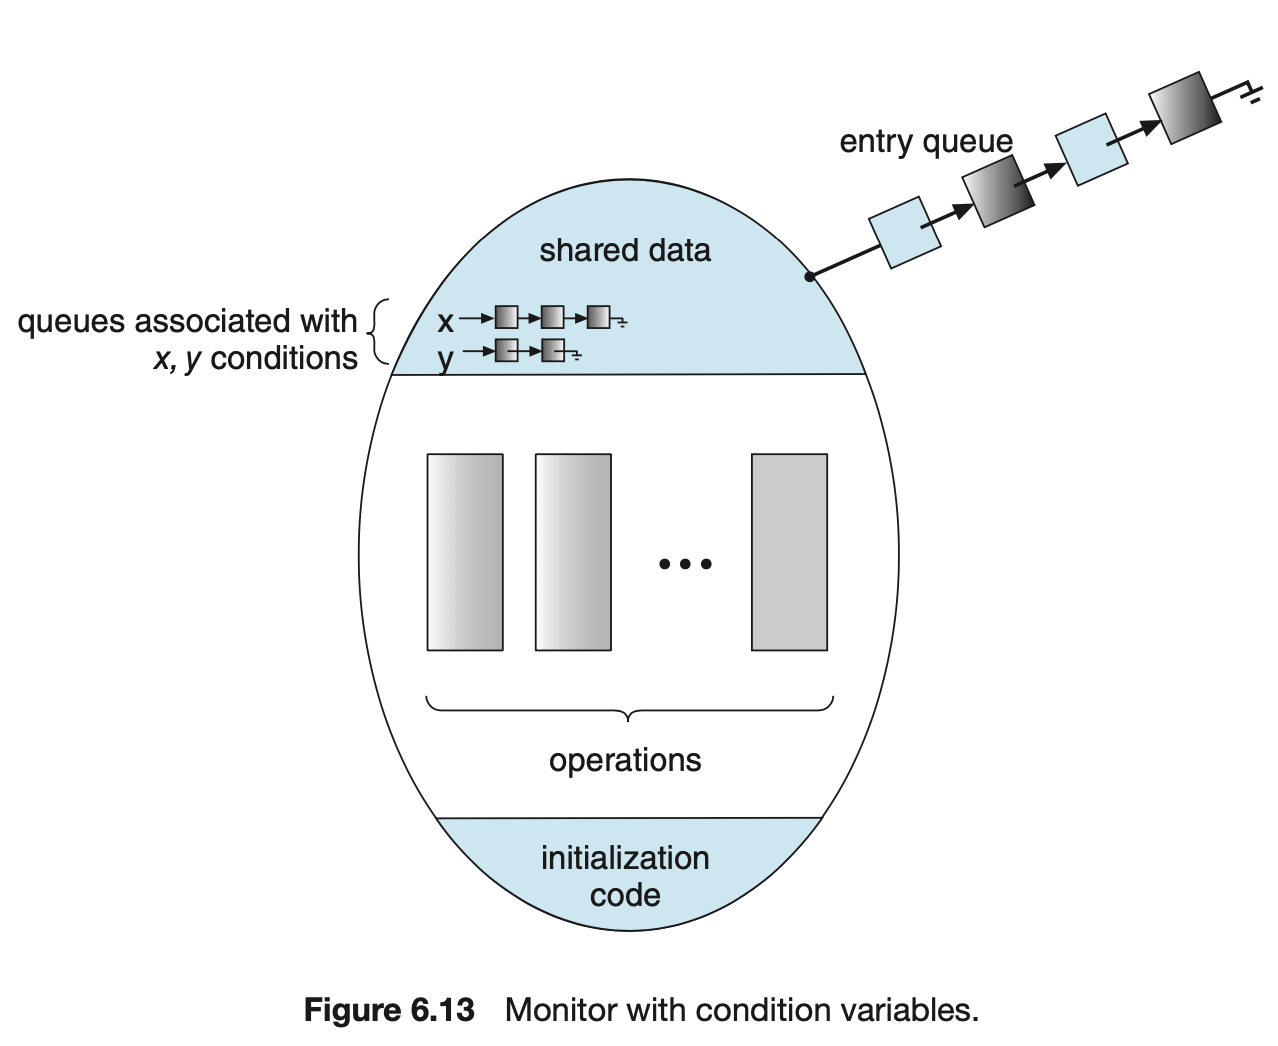

### Java Monitors
- Java provides a monitor-like concurrency mechanism for thread synchronization
- called __monitor-lock__ or __intrinsic-lock__

### Java Synchronization constructs
- __synchronized__ keyword for critical section
- __wait()__ method for wait function in monitor
- __notify()__ method for signal function in monitor

### synchronized keyword
- keyword for declaring critical section in code  
- __monitor lock(could be binary semaphore or mutuex lock)__ required for execution
- Applied to __Java Object instance__ as well as __Java Class method__

```java
/* applied to java object instance */
synchronized (object){
    // critical section 
}

/* applied to java class method */
public synchronized void add(){
    // critical section
}
```

### wait & notify method
- every Java object has wait & notify method
- thread call wait() method of an object 
    - wait until acquring monitor lock
- thread call notify() method of an object 
    - execute __one__ thread waiting for the monitor lock 
- thread call notifyAll() mtehod of an object
    - call __all__ threads waiting for the monitor lock 
    - job scheduler will pick one from the threads

### Java Synchronization Example 1
```java
public class SynchExample1 {
    static class Counter {
        public static int count = 0;
        public static void increment() {
            count++;
        }
    }
    
    static class MyRunnable implements Runnable {
        @Override
        public void run() {
            for (int i = 0; i < 10000; i++)
                Counter.increment();
        }
    }
    
    public static void main(String[] args) throws Exception { 
        Thread[] threads = new Thread[5];
        for (int i = 0; i < threads.length; i++) {
            threads[i] = new Thread(new MyRunnable());
            threads[i].start();
        }
        for (int i = 0; i < threads.length; i++)
            threads[i].join();
        System.out.println("counter = " + Counter.count); }
    }
}
```
- Creating static class Counter 
- Creating 5 threads
- 5 threads accesing 1 static class Counter.increment method -> Race Condition
- Expected Result = 50000
- Actual Result $\neq$ 50000
- Not Synchroized 

### Java Synchronization Example 2
```java
public class SynchExample2 {
    static class Counter {
        public static int count = 0;
        synchronized public static void increment() {
            count++;
        }
    }
    
    static class MyRunnable implements Runnable {
        @Override
        public void run() {
            for (int i = 0; i < 10000; i++)
                Counter.increment();
        }
    }
    
    public static void main(String[] args) throws Exception { 
        Thread[] threads = new Thread[5];
        for (int i = 0; i < threads.length; i++) {
            threads[i] = new Thread(new MyRunnable());
            threads[i].start();
        }
        for (int i = 0; i < threads.length; i++)
            threads[i].join();
        System.out.println("counter = " + Counter.count); }
    }
}
```
- Creating static class Counter 
- Creating 5 threads
- 5 threads accesing 1 static class Counter.increment method 
- ;however, making increment method as critrical section using __synchronized__ -> mutual exclusion
- Expected Result = 50000
- Actual Result $=$ 50000
- Synchronized 

### Java Synchronization Example 3
```java
public class SynchExample3 {
    static class Counter {
        private static Object object = new Object();
        public static int count = 0;
        public static void increment() {
            synchronized (object){
                count++;
            }
        }
    }
    
    static class MyRunnable implements Runnable {
        @Override
        public void run() {
            for (int i = 0; i < 10000; i++)
                Counter.increment();
        }
    }
    
    public static void main(String[] args) throws Exception { 
        Thread[] threads = new Thread[5];
        for (int i = 0; i < threads.length; i++) {
            threads[i] = new Thread(new MyRunnable());
            threads[i].start();
        }
        for (int i = 0; i < threads.length; i++)
            threads[i].join();
        System.out.println("counter = " + Counter.count); }
    }
}
```
- Creating static class Counter 
- Creating 5 threads
- 5 threads accesing 1 static class Counter.increment method 
- Instead of making increment method as critrical section, making only count++ as critical section __synchronized(object)__ -> mutual exclusion
- Expected Result = 50000
- Actual Result $=$ 50000
- Synchronized 

### Java Synchronization Example 4

```java
public class SynchExample4 {
    static class Counter {
        public static int count = 0;
        public static void increment() {
            synchronized (this){
                Counter.count++;
            }
        }
    }
    
    static class MyRunnable implements Runnable {
        Counter counter;
        public MyRunnable(Counter counter) {
            this.counter = counter;
        }
        @Override
        public void run() {
            for (int i = 0; i < 10000; i++)
                counter.increment();
        }
    }
    
    public static void main(String[] args) throws Exception { 
        Thread[] threads = new Thread[5];
        for (int i = 0; i < threads.length; i++) {
            threads[i] = new Thread(new MyRunnable(new Counter()));
            threads[i].start();
        }
        for (int i = 0; i < threads.length; i++)
            threads[i].join();
        System.out.println("counter = " + Counter.count); }
    }
}
```
- Creating 5 static class Counter 
- Creating 5 threads
- 5 threads accessing each 5 static class counter, calling count++;
- 5 static class counter instances synchronized itself using __synchronized (this)__ 
- ;however, count is static meaning __shared__ -> Race condition
- In short, 5 class counter instances synchroized with iteslf + 1 shared count variable...
- Expected Result = 50000
- Actual Result $\neq$ 50000
- Not Synchronized 

### Java Synchronization Example 5
```java
public class SynchExample5 {
    static class Counter {
        public static int count = 0;
        public statis void increment() {
            synchronized (this){
                Counter.count++;
            }
        }
    }
    
    static class MyRunnable implements Runnable {
        Counter counter;
        public MyRunnable(Counter counter) {
            this.counter = counter;
        }
        @Override
        public void run() {
            for (int i = 0; i < 10000; i++)
                counter.increment();
        }
    }
    
    public static void main(String[] args) throws Exception { 
        Thread[] threads = new Thread[5];
        Counter counter = new Counter();
        for (int i = 0; i < threads.length; i++) {
            threads[i] = new Thread(new MyRunnable(counter));
            threads[i].start();
        }
        for (int i = 0; i < threads.length; i++)
            threads[i].join();
        System.out.println("counter = " + Counter.count); }
    }
}
```
- Creating static class Counter 
- Creating 5 threads
- 5 threads accesing 1 static class Counter increment method
- Instead of making increment method as critrical section, making only count++ as critical section __synchronized(this)__ -> mutual exclusion
- Expected Result = 50000
- Actual Result $=$ 50000
- Synchronized 

# 6.8 Liveness

### Liveness
- Two criteria for the CSP: the progress and bounded-waiting
    - Mutex Locks, Semaphores, and , Monitors cannot solve these requirements. 
    - They are solutions only for Mutual Exclusion
    
- __Liveness__ is a set of properties that a system must satisfy to ensure that processes make __progress__ during their execution life cycle
- 즉 프로세스가 실행되는 동안 Progress 되는 것을 보장하기 위해 시스템이 충족해야하는 속성


### Liveness Failures
- A process waiting indefinitely
- Two Cases
    - Deadlock
    - Priority Inversion

### Dead Lock
- two or more processes are waiting indefinitely for an event that can be caused only by one of the waiting processes

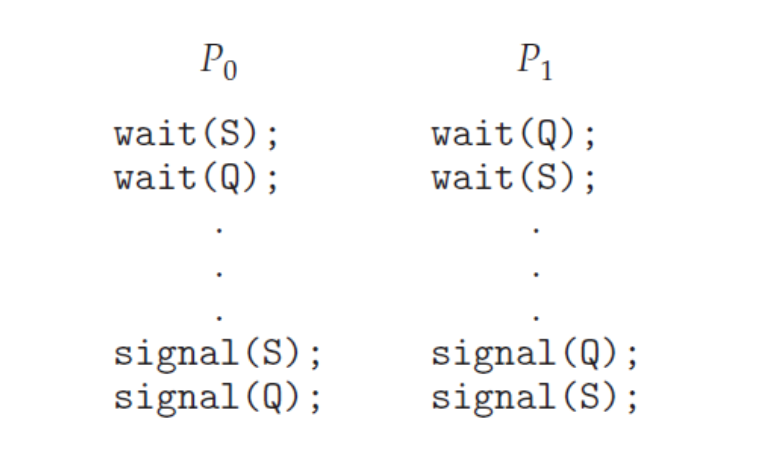

- Suppose that P0 executes wait(S)
    - P1 executes wait(Q); 
    - When P0 executes wait(Q), it must wait until P1 executes signal(Q). 
- Similarly, when P1 executes wait(S), it must wait until P0 executes signal(S)
- Since these signal() operations cannot be executed, P0 and P1 are deadlocked.

### Priority Inversion
- A situation where a higher-priority processes have to wait for a lower-priority one to finish the resource
- Priority inversion occurs when a high priority task is indirectly preempted by a low priority task. For example, the low priority task holds a mutex that the high priority task must wait for to continue executing


- The situation becomes more complicated if the lower-priority process is preempted in favor of another process with a higher priority.

#### Example
- three processes(L, M, H) whose priorities follow the order L < M < H
    - H excutes; wait for semaphore S on L
    - M executes since it has higher priority than L
    - M preempt the process L
    - L preempted by M w/out singal semaphore S
    - Then H will have to wait until L's singal of semaphore which will be executed after M finished its job
        - M finisheds
        - L executes until singal(s)
        - H preempt L
        - H finishes
    - L resumes and finishes
    - Then execution happend on following order: H -> M -> L -> H -> L
    - Jobs finished : M -> H -> L, which is not what we intended: H -> M -> L, called priority inversion.
    
### Priority-Inheritance Protocol
- solution for priority inversion
- all processes that are accessing resources needed by a higher-priority process inherit the higher priority until they are finished with the resources in question

#### Example
- three processes(L, M, H) whose priorities follow the order L < M < H
    - H executes; wait for semaphore S currently running by L
    - Priority of L temporarily switched to 'H' since it holds the semaphore S 
    - L executes until singal(s); priority then returns to L
    - L is preempted by H;
    - H finishes;
    - M finishes;
    - L resumed and finishes 
    - Then execution happend on following order: H -> L -> H -> M -> L
    - Jobs finished : H -> M -> L, which is what we intended: H -> M -> L